<a href="https://colab.research.google.com/github/ilmechaJu/OpenCV_Projects/blob/main/Bear_Face_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Models
- Bear face network from https://github.com/hypraptive/bearid-models
- Bear landmark network from https://github.com/kairess/dog_face_detector

In [3]:
#꼭 GPU로 실행해야됨! (Cuda Error 발생)
detector = dlib.cnn_face_detection_model_v1('./drive/MyDrive/Bread_Project/Bear-Face-Detection/models/bearface_network.dat') #강아지 얼굴 인식에 쓰던 dat임. (성능 개선하려면 dat파일 손봐야 함)
predictor = dlib.shape_predictor('./drive/MyDrive/Bread_Project/Bear-Face-Detection/models/landmarkDetector.dat')

# Load Image

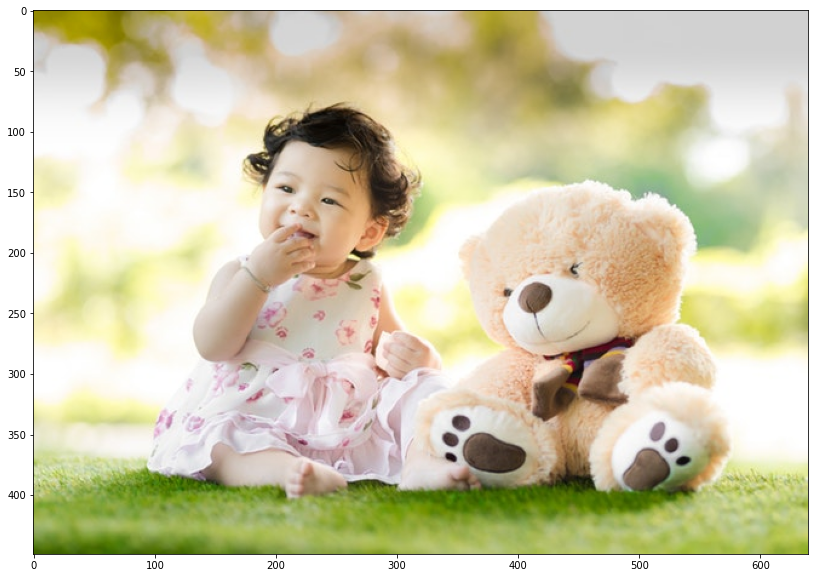

In [5]:
img = dlib.load_rgb_image('./drive/MyDrive/Bread_Project/Bear-Face-Detection/imgs/06.jpg')
img_result = img.copy()

plt.figure(figsize=(16, 10))
plt.imshow(img)

# Prediction

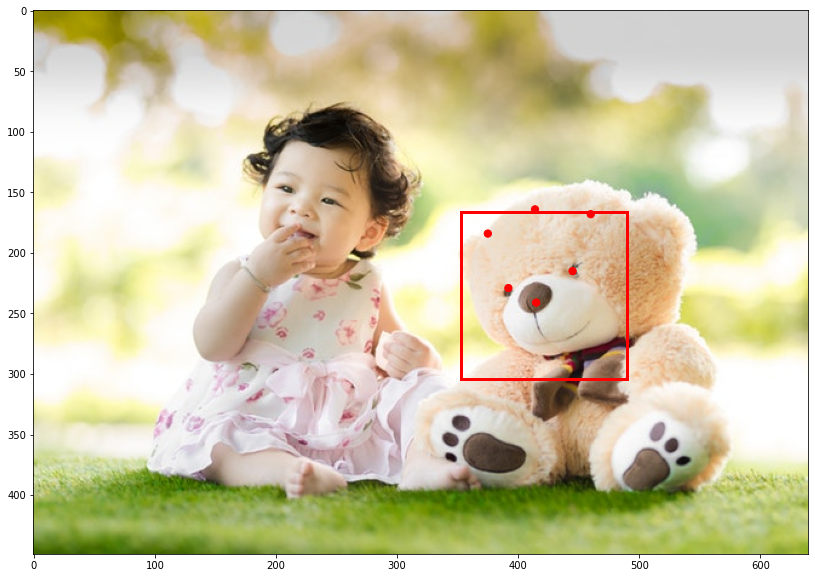

In [6]:
dets = detector(img)

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()

    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    shape = predictor(img, det.rect)

    for point in shape.parts():
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

# Multiple Images

In [7]:
from glob import glob

for img_path in glob('imgs/*.jpg'):
    img = dlib.load_rgb_image(img_path)
    img_result = img.copy()

    dets = detector(img)

    fig, ax = plt.subplots(1, figsize=(16, 10))

    for det in dets:
        x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()

        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        shape = predictor(img, det.rect)

        for point in shape.parts():
            circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
            ax.add_patch(circle)

    ax.imshow(img_result)

# Put Glasses On

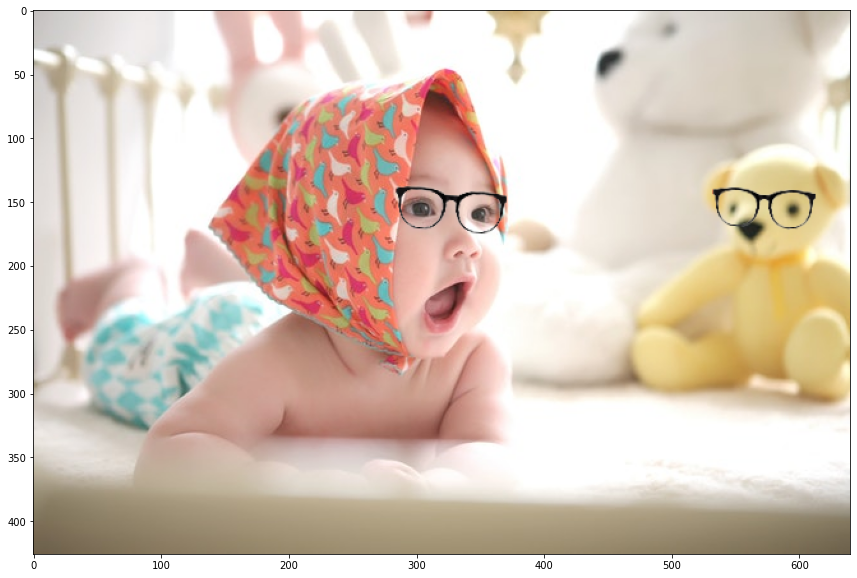

In [10]:
import numpy as np
import cv2
from imutils import face_utils
from math import atan2, degrees

img = dlib.load_rgb_image('./drive/MyDrive/Bread_Project/Bear-Face-Detection/imgs/05.jpg')
img_result = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2RGBA)
glasses = cv2.imread('./drive/MyDrive/Bread_Project/Bear-Face-Detection/imgs/glasses.png', cv2.IMREAD_UNCHANGED)
glasses = cv2.cvtColor(glasses, cv2.COLOR_RGB2RGBA)

dets = detector(img)

fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.rect.left(), det.rect.top(), det.rect.width(), det.rect.height()
    
    shape = predictor(img, det.rect)
    shape_np = face_utils.shape_to_np(shape)
    
    glasses_center = np.mean([shape_np[5], shape_np[2]], axis=0).astype(int)
    glasses_size = int(np.linalg.norm(shape_np[5] - shape_np[2]) * 1.8)
    
    glasses_resized = cv2.resize(glasses.copy(), dsize=(glasses_size, glasses_size))

    def angle_between(p1, p2):
        xDiff = p2[0] - p1[0]
        yDiff = p2[1] - p1[1]
        return degrees(atan2(yDiff, xDiff))

    angle = -angle_between(shape_np[5], shape_np[2])
    M = cv2.getRotationMatrix2D((glasses_resized.shape[1] / 2, glasses_resized.shape[0] / 2), angle, 1)
    rotated_glasses = cv2.warpAffine(
        glasses_resized.copy(),
        M,
        (glasses_size, glasses_size),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=255
    )
    
    x_offset, y_offset = glasses_center - np.array([rotated_glasses.shape[1] / 2, rotated_glasses.shape[0] / 2], dtype=int)

    y1, y2 = y_offset, y_offset + glasses_size
    x1, x2 = x_offset, x_offset + glasses_size

    alpha_s = rotated_glasses[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        img_result[y1:y2, x1:x2, c] = (alpha_s * rotated_glasses[:, :, c] + alpha_l * img_result[y1:y2, x1:x2, c])

ax.imshow(img_result)